In [1]:

import itertools
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm
from dataclasses import asdict, dataclass, field
import vsketch
import shapely.geometry as sg
from shapely.geometry import box, MultiLineString, Point, MultiPoint, Polygon, MultiPolygon, LineString
import shapely.affinity as sa
import shapely.ops as so
import matplotlib.pyplot as plt
import pandas as pd

import vpype_cli
from typing import List, Generic
from genpen import genpen as gp
from genpen.utils import Paper
from scipy import stats
import geopandas
from shapely.errors import TopologicalError
import functools
import vpype
from skimage import io
from pathlib import Path

from sklearn.preprocessing import minmax_scale
from skimage import feature
from skimage import exposure
from torch import Tensor
from torch import nn
from skimage import filters
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.morphology import disk
from numpy.random import default_rng


from PIL import Image
import attr

import cv2
from rasterio import features
import rasterio

import pydiffvg as dg
import torch
import skimage
import numpy as np
from torchvision.transforms import functional as TF
from IPython import display
from copy import deepcopy
import fn
import torch.nn.functional as F

from tempfile import NamedTemporaryFile
from genpen.diffvg import diffvg as gdg
import clip
import copy

%load_ext autoreload
%autoreload 2

In [2]:
# Use GPU if available

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
clip_model, preprocess = clip.load("ViT-B/32", device=device)
dg.set_device(device)

In [3]:
from genpen.diffvg.diffvg import (
    ParamHead, ShapeGroupMaker, 
    ShapeMaker, LazySigmoid, LazyHardsigmoid,
    CanvasNet, LazyRelu,
    CanvasNIMANet, CanvasCLIPNet, init_weights,
    EdgeToEdgeDistanceLoss, OutOfBoundsLoss, TargetImageLoss,
    NIMALoss, CLIPLoss
    )

def rescale(x, min_val, max_val):
    min_val = torch.tensor(min_val)
    max_val = torch.tensor(max_val)
    return x * (max_val - min_val) + min_val

class Rescaler(nn.Module):
    def __init__(self, min_val, max_val):
        super().__init__()
        self.min_val = min_val
        self.max_val = max_val
        
    def forward(self, x):
        return x * (self.max_val - self.min_val) + self.min_val

class Reshape(nn.Module):
    
    def __init__(self, dims):
        super().__init__()
        self.dims = dims
        
    def forward(self, x):
        return x.view(self.dims)
    
class SigmoidParameter(nn.Module):
    
    def __init__(self, n_shapes, n_params):
        super().__init__()
        self.n_shapes = n_shapes
        self.n_params = n_params
        self.net = nn.Sequential(
            LazyHardsigmoid(n_params*n_shapes),
            Reshape((n_shapes, n_params)),
        )
        
    def forward(self, x):
        return self.net(x)
    
class Squeezer(nn.Module):
    
    def forward(self, x):
        return x.squeeze()
    
def train(canvas_net, optim, loss_weights=None):
    
    outputs = canvas_net.forward()
    tensors = outputs['tensors']
    shapes = outputs['shapes']
    shape_groups = outputs['shape_groups']
    optim.zero_grad()
    losses = {}
    if loss_weights is None:
        loss_weights = {
            'big_rad_loss': 1,
            'overlap_loss': 1,
            'distance_loss': 1,
            'out_of_bounds_loss': 1,
            
        }
    overlap_buffer = 0
    shapes_tensors = tensors['shapes_tensors']
    # big rad 
    losses['big_rad_loss'] = shapes_tensors['radius'].exp().sum()

    # prevent overlap
    dists = torch.cdist(shapes_tensors['center'], shapes_tensors['center'])
    upper_dists = torch.triu(dists)
    nonzero_inds = torch.nonzero(upper_dists, as_tuple=True)
    dists[nonzero_inds]
    summed_rads = torch.atleast_2d(shapes_tensors['radius']).T + torch.atleast_2d(shapes_tensors['radius'])
    edge_to_edge_dists = dists[nonzero_inds] - summed_rads[nonzero_inds] - overlap_buffer
    losses['overlap_loss'] = F.relu(-edge_to_edge_dists).pow(3).sum()
    losses['distance_loss'] = edge_to_edge_dists.pow(2).sum()
    scaled_losses = {key: loss*loss_weights[key] for key, loss in losses.items()}
    loss = sum(scaled_losses.values())

    loss.backward()
    optim.step()
    
    scaled_losses['loss'] = loss
    return losses, scaled_losses, shapes, shape_groups, tensors

def train_nima(canvas_nima_net, optim, model_ft, canvas):
    
    optim.zero_grad()
    
    shapes, shape_groups, tensors, img = canvas_nima_net.forward()
    loss = canvas_nima_net.nima_loss(img)

    loss.backward()
    optim.step()
    
    return loss, shapes, shape_groups, tensors, img

def train_clip(canvas_clip_net, optim):
    
    optim.zero_grad()
    
    shapes, shape_groups, tensors, img = canvas_clip_net.forward()
    img.retain_grad()
    losses = canvas_clip_net.get_clip_losses(img)
    loss = torch.sum(*losses)

    loss.backward()
    optim.step()
    
    
    return loss, losses, shapes, shape_groups, tensors, img

def train_img(canvas_net, optim, target_img):
    
    optim.zero_grad()
    
    shapes, shape_groups, tensors, img = canvas_net.forward(torch.tensor([0.5], device=canvas_net.device))
    
    loss = ((target_img - img) ** 2).mean()

    loss.backward(retain_graph=True)
    optim.step()
    
    
    return loss, shapes, shape_groups, tensors, img

In [4]:
def train_flex(canvas_net, optim, loss_funcs, loss_weights=None, clipping_value=1):
    outputs = canvas_net.forward()
    optim.zero_grad()
    if loss_weights is None:
        loss_weights = {key:1. for key in loss_funcs.keys()}
        
    losses = {key: torch.atleast_1d(loss_func.forward(outputs)) for key, loss_func in loss_funcs.items()}
    scaled_losses = {key: loss*loss_weights[key] for key, loss in losses.items()}
    loss = sum(scaled_losses.values())
    loss.backward()
    
     # arbitrary value of your choosing
    torch.nn.utils.clip_grad_norm(canvas_net.parameters(), clipping_value)
    
    optim.step()
    return outputs, losses, scaled_losses, loss

In [93]:
n_shapes = 1400
shape_param_head = ParamHead(nets={
    'center': SigmoidParameter(n_shapes, 2),
    'radius': nn.Sequential(SigmoidParameter(n_shapes, 1), Squeezer()),
    'stroke_width': nn.Sequential(SigmoidParameter(n_shapes, 1), Squeezer()),
})

param_transforms = {
    'center': Rescaler(0., 224.),
    'radius': Rescaler(0.2, 10.1),
    'stroke_width': Rescaler( 1., 2.1),
}


shape_maker = ShapeMaker(
    shape_class=dg.Circle, 
    n_shapes=n_shapes,
    param_transforms=param_transforms,
    base_id=0,
    )

shape_head = nn.Sequential(shape_param_head, shape_maker)

shape_groups_param_head = ParamHead(nets={
    'stroke_color': nn.Sequential(SigmoidParameter(1, 4), Squeezer()),  
    'fill_color': nn.Sequential(SigmoidParameter(1, 4), Squeezer()),  
})
shape_groups_maker = ShapeGroupMaker(
    shape_ids=shape_maker.ids,
    param_transforms={
        'stroke_color': lambda x: torch.tensor([0., 0., 0., 1.]),
        'fill_color': lambda x: torch.tensor([1., 1., 1., 1.]),
        }
    )
shape_groups_head = nn.Sequential(shape_groups_param_head, shape_groups_maker)

canvas = gdg.Canvas(width=224, height=224, draw_white_background=True)
canvas_net = CanvasNet(
    backbone=nn.Sequential(
        nn.Linear(1, 256),
        nn.ReLU(),
        LazyRelu(512),
        LazyRelu(512),
        LazyRelu(512),
    ),
    shapes_head=shape_head,
    shape_groups_head=shape_groups_head,
    canvas=canvas,
).to(device)
canvas_clip_net = CanvasCLIPNet(canvas_net, perceptor=clip_model).to(device)

In [94]:
upscaler = copy.deepcopy(shape_maker)

In [245]:

shape_groups = outputs['shape_groups']
with torch.no_grad():
    shapes_tensors = outputs['tensors']['shapes_tensors']
    upscaled_shapes_tensors = {key: tensor.clone() for key, tensor in shapes_tensors.items()}
    shapes, upscaled_tensors = upscaler.forward(upscaled_shapes_tensors)
canvas = gdg.Canvas(width=int(224*upscale_factor), height=int(224*upscale_factor), draw_white_background=True)
canvas.render(shapes, shape_groups, as_pil=True)
gdg.to_pil(nn.functional.interpolate(img, size=(600, 600), mode='nearest-exact'))

NameError: name 'upscale_factor' is not defined

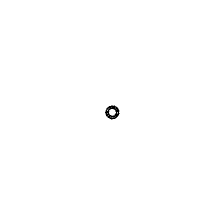

In [96]:
outputs = canvas_clip_net.forward()
canvas_clip_net.canvas_net.apply(init_weights);
outputs = canvas_clip_net.forward()

gdg.to_pil(outputs['img'])

tensor([0.0001], device='cuda:0', grad_fn=<AddBackward0>)
{'overlap_loss': 6e-05, 'out_of_bounds_loss': 5e-05}


/tmp/ipykernel_19094/1966351761.py:13: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(canvas_net.parameters(), clipping_value)


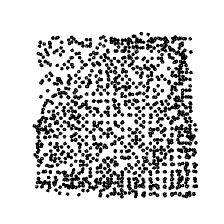

In [92]:
optim = torch.optim.Adam(canvas_net.parameters(), lr=3e-4)
loss_funcs = {
    'overlap_loss': EdgeToEdgeDistanceLoss(safe_distance=1),
    'out_of_bounds_loss': OutOfBoundsLoss(left=24,right=200, bottom=24, top=200),
    }
loss_weights = {
    'overlap_loss': 1e-1,
    'out_of_bounds_loss': 1e-1,
}
outputs, losses, scaled_losses, loss = train_flex(
    canvas_net=canvas_net, 
    optim=optim, 
    loss_funcs=loss_funcs,
    loss_weights=loss_weights,
    )
print(loss)
print({k: np.round(float(v),5) for k, v in scaled_losses.items()})
img = outputs['img']
gdg.to_pil(img)

In [41]:
target_img = img.clone()

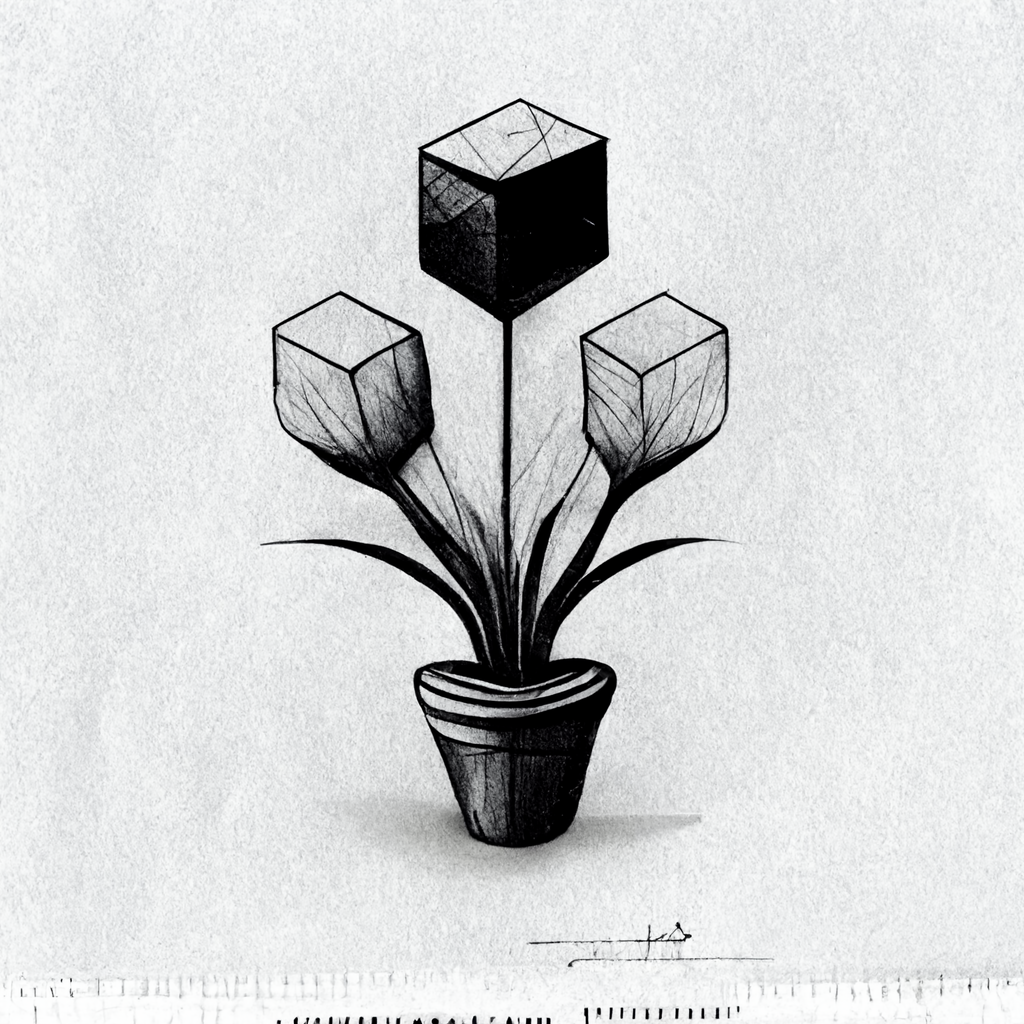

In [99]:
target_img

In [75]:
optim = torch.optim.Adam(canvas_net.parameters(), lr=3e-3)
target_img_loss = TargetImageLoss(target_img=target_img)
loss_funcs = {
    'target_img_loss': target_img_loss,
    'overlap_loss': EdgeToEdgeDistanceLoss(safe_distance=1),
    'out_of_bounds_loss': OutOfBoundsLoss(left=24,right=200, bottom=24, top=200),
    'nima_loss': NIMALoss()
    }
loss_weights = {
    'target_img_loss': 1e0,
    'overlap_loss': 1e-1,
    'out_of_bounds_loss': 1e-2,
    'nima_loss': 1e-6,
}

tensor([55.0737], device='cuda:0', grad_fn=<AddBackward0>)
{'target_img_loss': 0.06522, 'overlap_loss': 54.87096, 'out_of_bounds_loss': 0.13757, 'nima_loss': -1e-05}


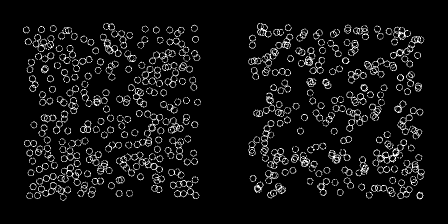

In [94]:
outputs, losses, scaled_losses, loss = train_flex(
    canvas_net=canvas_net, 
    optim=optim, 
    loss_funcs=loss_funcs,
    loss_weights=loss_weights,
    )
print(loss)
print({k: np.round(float(v),5) for k, v in scaled_losses.items()})
img = outputs['img']
gdg.to_pil(torch.cat((img, target_img), dim=3))

  1%|          | 8/1000 [00:00<00:27, 35.66it/s]

tensor([0.0840], device='cuda:0', grad_fn=<AddBackward0>)


 10%|█         | 105/1000 [00:02<00:23, 38.33it/s]

tensor([0.0804], device='cuda:0', grad_fn=<AddBackward0>)


 21%|██        | 206/1000 [00:05<00:22, 35.78it/s]

tensor([0.0762], device='cuda:0', grad_fn=<AddBackward0>)


 31%|███       | 309/1000 [00:08<00:17, 40.03it/s]

tensor([0.0725], device='cuda:0', grad_fn=<AddBackward0>)


 41%|████      | 409/1000 [00:11<00:16, 34.92it/s]

tensor([0.0723], device='cuda:0', grad_fn=<AddBackward0>)


 51%|█████     | 508/1000 [00:14<00:12, 38.77it/s]

tensor([0.0706], device='cuda:0', grad_fn=<AddBackward0>)


 61%|██████    | 607/1000 [00:17<00:10, 35.84it/s]

tensor([0.0712], device='cuda:0', grad_fn=<AddBackward0>)


 71%|███████   | 708/1000 [00:19<00:07, 39.09it/s]

tensor([0.0692], device='cuda:0', grad_fn=<AddBackward0>)


 81%|████████  | 806/1000 [00:22<00:04, 40.78it/s]

tensor([0.0697], device='cuda:0', grad_fn=<AddBackward0>)


 91%|█████████ | 907/1000 [00:25<00:02, 34.58it/s]

tensor([0.0684], device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 1000/1000 [00:28<00:00, 35.43it/s]

tensor([0.0681], device='cuda:0', grad_fn=<AddBackward0>)
{'target_img_loss': 0.06438, 'overlap_loss': 0.0, 'out_of_bounds_loss': 0.00372}


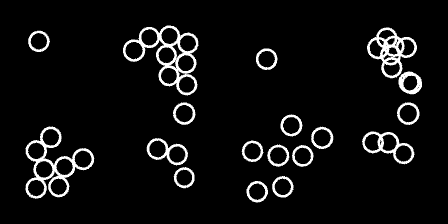

In [485]:
for ii in tqdm(range(1000)):
    outputs, losses, scaled_losses, loss = train_flex(
        canvas_net=canvas_net, 
        optim=optim, 
        loss_funcs=loss_funcs,
        loss_weights=loss_weights,
        )
    if ii % 100 == 0:
        print(loss)
print(loss)
print({k: np.round(float(v),5) for k, v in scaled_losses.items()})
img = outputs['img']
gdg.to_pil(torch.cat((img, target_img), dim=3))

In [484]:
optim = torch.optim.Adam(canvas_net.parameters(), lr=3e-4)
target_img_loss = TargetImageLoss(target_img=target_img)
loss_funcs = {
    # 'target_img_loss': target_img_loss,
    'overlap_loss': EdgeToEdgeDistanceLoss(safe_distance=0),
    'out_of_bounds_loss': OutOfBoundsLoss(left=12,right=212, bottom=12, top=212),
    'nima_loss': NIMALoss()
    }
loss_weights = {
    # 'target_img_loss': 1e0,
    'overlap_loss': 1e-4,
    'out_of_bounds_loss': 1e-2,
    'nima_loss': 1e0,
}

tensor([-5.2553], device='cuda:0', grad_fn=<AddBackward0>)
{'overlap_loss': 0.09435, 'out_of_bounds_loss': 3e-05, 'nima_loss': -5.34964}


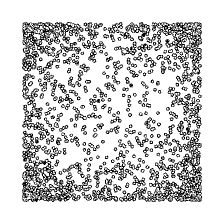

In [497]:
outputs, losses, scaled_losses, loss = train_flex(
    canvas_net=canvas_net, 
    optim=optim, 
    loss_funcs=loss_funcs,
    loss_weights=loss_weights,
    )
print(loss)
print({k: np.round(float(v),5) for k, v in scaled_losses.items()})
img = outputs['img']
# gdg.to_pil(torch.cat((img, target_img), dim=3))
gdg.to_pil(img)

  0%|          | 1/500 [00:00<03:44,  2.22it/s]

tensor([-5.2346], device='cuda:0', grad_fn=<AddBackward0>)


 20%|██        | 101/500 [00:48<03:08,  2.12it/s]

tensor([-5.2346], device='cuda:0', grad_fn=<AddBackward0>)


 40%|████      | 201/500 [01:36<02:21,  2.11it/s]

tensor([-5.2014], device='cuda:0', grad_fn=<AddBackward0>)


 60%|██████    | 301/500 [02:24<01:34,  2.12it/s]

tensor([-5.2072], device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████  | 401/500 [03:13<00:46,  2.12it/s]

tensor([-5.1844], device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 500/500 [04:00<00:00,  2.08it/s]

tensor([-5.2010], device='cuda:0', grad_fn=<AddBackward0>)
{'overlap_loss': 0.15737, 'out_of_bounds_loss': 3e-05, 'nima_loss': -5.35835}


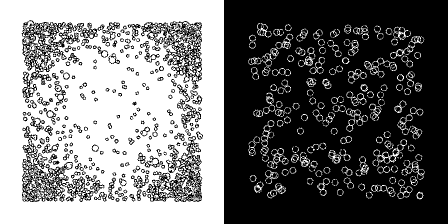

In [498]:
for ii in tqdm(range(500)):
    outputs, losses, scaled_losses, loss = train_flex(
    canvas_net=canvas_net, 
    optim=optim, 
    loss_funcs=loss_funcs,
    loss_weights=loss_weights,
    )
    if ii % 100 == 0:
        print(loss)
print(loss)
print({k: np.round(float(v),5) for k, v in scaled_losses.items()})
img = outputs['img']
gdg.to_pil(torch.cat((img, target_img), dim=3))

In [20]:
clip_loss = CLIPLoss()

In [21]:
clip_loss.set_text_prompts(['Beautiful clouds made out of black circles'])

In [22]:
optim = torch.optim.Adam(canvas_net.parameters(), lr=3e-4)
loss_funcs = {
    'overlap_loss': EdgeToEdgeDistanceLoss(safe_distance=3),
    'out_of_bounds_loss': OutOfBoundsLoss(left=12,right=212, bottom=12, top=212),
    # 'nima_loss': NIMALoss(),
    'clip_loss': clip_loss, 
    }
loss_weights = {
    'overlap_loss': 1e1,
    'out_of_bounds_loss': 1e-2,
    # 'nima_loss': 1e0,
    'clip_loss': 1e1
}

tensor([5.6381], device='cuda:0', grad_fn=<AddBackward0>)
{'overlap_loss': 11.31991, 'out_of_bounds_loss': 0.0, 'nima_loss': -5.68183}


/tmp/ipykernel_894935/1966351761.py:13: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(canvas_net.parameters(), clipping_value)


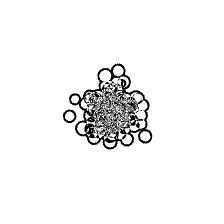

In [653]:
outputs, losses, scaled_losses, loss = train_flex(
    canvas_net=canvas_net, 
    optim=optim, 
    loss_funcs=loss_funcs,
    loss_weights=loss_weights,
    )
print(loss)
print({k: np.round(float(v),5) for k, v in scaled_losses.items()})
img = outputs['img']
# gdg.to_pil(torch.cat((img, target_img), dim=3))
gdg.to_pil(img)

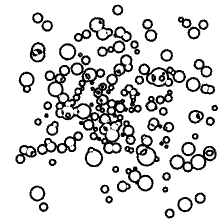

 98%|█████████▊| 492/500 [00:51<00:00,  9.68it/s]

{'overlap_loss': 0.21607, 'out_of_bounds_loss': 0.01856, 'nima_loss': -5.68633}


100%|██████████| 500/500 [00:52<00:00,  9.53it/s]

tensor([-5.3814], device='cuda:0', grad_fn=<AddBackward0>)
{'overlap_loss': 0.24989, 'out_of_bounds_loss': 0.0343, 'nima_loss': -5.66556}


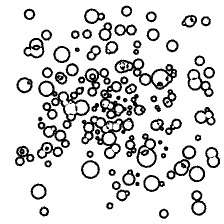

In [654]:
for ii in tqdm(range(500)):
    outputs, losses, scaled_losses, loss = train_flex(
    canvas_net=canvas_net, 
    optim=optim, 
    loss_funcs=loss_funcs,
    loss_weights=loss_weights,
    )
    if ii % 10 == 0:
        
        display.clear_output(wait=True)
        temp = NamedTemporaryFile(mode="wb", suffix='.png', delete=False)
        with  temp as fp:
            gdg.to_pil(outputs['img']).save(fp)
        display.display(display.Image(temp.name))
        print({k: np.round(float(v),5) for k, v in scaled_losses.items()})
print(loss)
print({k: np.round(float(v),5) for k, v in scaled_losses.items()})
img = outputs['img']
gdg.to_pil(img)

In [303]:
nft_id = fn.new_nft_id()

raster_videos_dir = Path('/home/naka/art/raster_videos')
nft_dir = raster_videos_dir.joinpath(nft_id)

if not nft_dir.exists():
    os.mkdir(nft_dir) 
    
frame_counter = 0

saved 20220704-165720_363770-c759e-4904f6 to s3://algorithmic-ink/current_nft_id


In [341]:
class Mult(nn.Module):
    
    def __init__(self, factor):
        super().__init__()
        self.factor = factor
        
    def forward(self, x):
        return x * self.factor
    
upscale_factor = 5.
upscaler_param_transforms = {
    'center': Mult(upscale_factor),
    'radius': Mult(upscale_factor),
    'stroke_width': Mult(upscale_factor),
}

upscaler = ShapeMaker(
    shape_class=dg.Circle, 
    n_shapes=n_shapes,
    param_transforms=upscaler_param_transforms,
    base_id=0,
    )

In [342]:
save_freq = 1
frame_counter = 0


In [397]:
optim = torch.optim.Adam(canvas_net.parameters(), lr=3e-3)


In [398]:
clip_loss.set_text_prompts(['Amazing monochrome abstract art'])
loss_funcs = {
    'overlap_loss': EdgeToEdgeDistanceLoss(safe_distance=0.),
    'out_of_bounds_loss': OutOfBoundsLoss(left=0,right=224, bottom=0, top=224),
    'nima_loss': NIMALoss(),
    'clip_loss': clip_loss, 
    }
loss_weights = {
    'overlap_loss': -1e6,
    'out_of_bounds_loss': 1e6,
    'nima_loss': 1e0,
    'clip_loss': 1e0
}

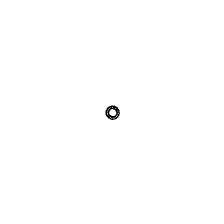

100%|██████████| 30/30 [00:18<00:00,  1.67it/s]

{'overlap_loss': -10818398.0, 'out_of_bounds_loss': 0.0, 'nima_loss': -6.23294, 'clip_loss': 0.31468}
tensor([-10818404.], device='cuda:0', grad_fn=<AddBackward0>)
{'overlap_loss': -10818398.0, 'out_of_bounds_loss': 0.0, 'nima_loss': -6.23294, 'clip_loss': 0.31468}


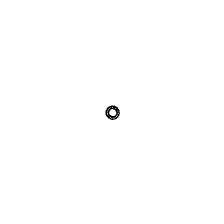

In [401]:

for ii in tqdm(range(30)):
    outputs, losses, scaled_losses, loss = train_flex(
    canvas_net=canvas_net, 
    optim=optim, 
    loss_funcs=loss_funcs,
    loss_weights=loss_weights,
    )
    if ii % save_freq == 0:
        
        display.clear_output(wait=True)
        temp = NamedTemporaryFile(mode="wb", suffix='.png', delete=False)
        with  temp as fp:
            gdg.to_pil(outputs['img']).save(fp)
        display.display(display.Image(temp.name))
        
        fp = nft_dir.joinpath(f'{frame_counter:04d}.png')
        # gdg.to_pil(outputs['img']).save(fp)
        
        shape_groups = outputs['shape_groups']
        with torch.no_grad():
            shapes_tensors = outputs['tensors']['shapes_tensors']
            upscaled_shapes_tensors = {key: tensor.clone() for key, tensor in shapes_tensors.items()}
            shapes, upscaled_tensors = upscaler.forward(upscaled_shapes_tensors)
        canvas = gdg.Canvas(width=int(224*upscale_factor), height=int(224*upscale_factor), draw_white_background=True)
        canvas.render(shapes, shape_groups, as_pil=True).save(fp)
        
        
        frame_counter += 1
        print({k: np.round(float(v),5) for k, v in scaled_losses.items()})
print(loss)
print({k: np.round(float(v),5) for k, v in scaled_losses.items()})
img = outputs['img']
gdg.to_pil(img)

In [5]:
nft_dir = Path('/home/naka/art/raster_videos/20220704-153306_850908-c759e-4e0e0b')

In [7]:
nft_id = '20220704-153306_850908-c759e-4e0e0b'

In [402]:
filenames = sorted([fp.as_posix() for fp in nft_dir.glob('*.png')])
import moviepy
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
clipout = ImageSequenceClip(filenames, fps=60)
clipout.write_videofile(nft_dir.joinpath(f'{nft_id}.mp4').as_posix())
len(filenames)

t:   0%|          | 0/1025 [00:00<?, ?it/s, now=None]

Moviepy - Building video /home/naka/art/raster_videos/20220704-165720_363770-c759e-4904f6/20220704-165720_363770-c759e-4904f6.mp4.
Moviepy - Writing video /home/naka/art/raster_videos/20220704-165720_363770-c759e-4904f6/20220704-165720_363770-c759e-4904f6.mp4



Moviepy - Done !
Moviepy - video ready /home/naka/art/raster_videos/20220704-165720_363770-c759e-4904f6/20220704-165720_363770-c759e-4904f6.mp4


1024

# just image

In [295]:
n_shapes = 2000
shape_param_head = ParamHead(nets={
    'center': SigmoidParameter(n_shapes, 2),
    'radius': nn.Sequential(SigmoidParameter(n_shapes, 1), Squeezer()),
    'stroke_width': nn.Sequential(SigmoidParameter(n_shapes, 1), Squeezer()),
})

param_transforms = {
    'center': Rescaler(0., 224.),
    'radius': Rescaler(0.1, 1.1),
    'stroke_width': Rescaler( 0.5, 1.1),
}


shape_maker = ShapeMaker(
    shape_class=dg.Circle, 
    n_shapes=n_shapes,
    param_transforms=param_transforms,
    base_id=0,
    )

shape_head = nn.Sequential(shape_param_head, shape_maker)

shape_groups_param_head = ParamHead(nets={
    'stroke_color': nn.Sequential(SigmoidParameter(1, 4), Squeezer()),  
    'fill_color': nn.Sequential(SigmoidParameter(1, 4), Squeezer()),  
})
shape_groups_maker = ShapeGroupMaker(
    shape_ids=shape_maker.ids,
    param_transforms={
        'stroke_color': lambda x: torch.tensor([0., 0., 0., 1.]),
        'fill_color': lambda x: torch.tensor([1., 1., 1., 1.]),
        }
    )
shape_groups_head = nn.Sequential(shape_groups_param_head, shape_groups_maker)

canvas = gdg.Canvas(width=224, height=224, draw_white_background=True)
canvas_net = CanvasNet(
    backbone=nn.Sequential(
        nn.Linear(1, 256),
        nn.ReLU(),
        LazyRelu(512),
        LazyRelu(512),
        LazyRelu(512),
    ),
    shapes_head=shape_head,
    shape_groups_head=shape_groups_head,
    canvas=canvas,
).to(device)
canvas_clip_net = CanvasCLIPNet(canvas_net, perceptor=clip_model).to(device)

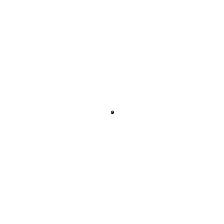

In [296]:
outputs = canvas_clip_net.forward()
canvas_clip_net.canvas_net.apply(init_weights);
outputs = canvas_clip_net.forward()

gdg.to_pil(outputs['img'])

In [ ]:
from torchvision.transforms import ToTensor, Resize

In [180]:
target_img = Image.open('/home/naka/Downloads/naka_A_minimalist_isometric_line_drawing_of_a_beautiful_potted__8e8550d9-cf2b-4871-abdb-628f4de3f90a.png')
target_img = ToTensor()(target_img)
target_img = Resize((224,224))(target_img).cuda()
target_img = target_img.unsqueeze(0)

In [213]:
optim = torch.optim.Adam(canvas_net.parameters(), lr=3e-3)
target_img_loss = TargetImageLoss(target_img=target_img)
loss_funcs = {
    'target_img_loss': target_img_loss,
    'overlap_loss': EdgeToEdgeDistanceLoss(safe_distance=1),
    'out_of_bounds_loss': OutOfBoundsLoss(left=24,right=200, bottom=24, top=200),
    # 'nima_loss': NIMALoss()
    }
loss_weights = {
    'target_img_loss': 1e0,
    'overlap_loss': 1e0,
    'out_of_bounds_loss': 1e-4,
    # 'nima_loss': 1e-6,
}

tensor([0.0750], device='cuda:0', grad_fn=<AddBackward0>)
{'target_img_loss': 0.07122, 'overlap_loss': 0.00382, 'out_of_bounds_loss': 0.0}


/tmp/ipykernel_19094/1966351761.py:13: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(canvas_net.parameters(), clipping_value)


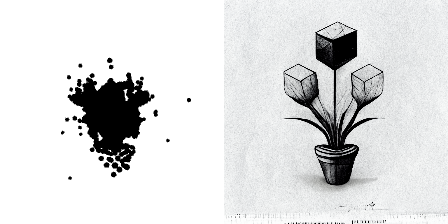

In [243]:
outputs, losses, scaled_losses, loss = train_flex(
    canvas_net=canvas_net, 
    optim=optim, 
    loss_funcs=loss_funcs,
    loss_weights=loss_weights,
    )
print(loss)
print({k: np.round(float(v),5) for k, v in scaled_losses.items()})
img = outputs['img']
gdg.to_pil(torch.cat((img, target_img), dim=3))

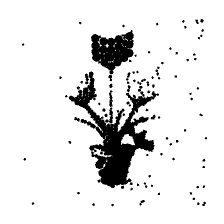

 98%|█████████▊| 491/500 [02:36<00:02,  3.11it/s]

{'target_img_loss': 0.03116, 'overlap_loss': 0.00075, 'out_of_bounds_loss': 0.00013}


100%|██████████| 500/500 [02:39<00:00,  3.13it/s]

tensor([0.0328], device='cuda:0', grad_fn=<AddBackward0>)
{'target_img_loss': 0.03191, 'overlap_loss': 0.0008, 'out_of_bounds_loss': 9e-05}


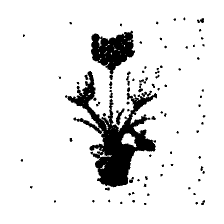

In [244]:
for ii in tqdm(range(500)):
    outputs, losses, scaled_losses, loss = train_flex(
    canvas_net=canvas_net, 
    optim=optim, 
    loss_funcs=loss_funcs,
    loss_weights=loss_weights,
    )
    if ii % 10 == 0:
        
        display.clear_output(wait=True)
        temp = NamedTemporaryFile(mode="wb", suffix='.png', delete=False)
        with  temp as fp:
            gdg.to_pil(outputs['img']).save(fp)
        display.display(display.Image(temp.name))
        print({k: np.round(float(v),5) for k, v in scaled_losses.items()})
print(loss)
print({k: np.round(float(v),5) for k, v in scaled_losses.items()})
img = outputs['img']
gdg.to_pil(img)

In [254]:
shapes_tensors

{'center': tensor([[112.3945, 112.3808],
         [112.3614, 112.3862],
         [112.4313, 112.3262],
         ...,
         [112.3508, 112.3333],
         [112.3325, 112.3919],
         [112.3193, 112.3386]], device='cuda:0', grad_fn=<AddBackward0>),
 'radius': tensor([1.1533, 1.1530, 1.1536,  ..., 1.1532, 1.1536, 1.1537], device='cuda:0',
        grad_fn=<AddBackward0>),
 'stroke_width': tensor([1.5521, 1.5517, 1.5517,  ..., 1.5511, 1.5513, 1.5518], device='cuda:0',
        grad_fn=<AddBackward0>)}

In [264]:
nft_id = fn.new_nft_id()

raster_videos_dir = Path('/home/naka/art/raster_videos')
nft_dir = raster_videos_dir.joinpath(nft_id)

if not nft_dir.exists():
    os.mkdir(nft_dir) 
    
frame_counter = 0

saved 20220821-125609_095552-793c6-6ac7a9 to s3://algorithmic-ink/current_nft_id


In [278]:
class Mult(nn.Module):
    
    def __init__(self, factor):
        super().__init__()
        self.factor = factor
        
    def forward(self, x):
        return x * self.factor
    
upscale_factor = 5.
upscaler_param_transforms = {
    'center': Mult(upscale_factor),
    'radius': Mult(upscale_factor),
    'stroke_width': Mult(upscale_factor),
}

upscaler = ShapeMaker(
    shape_class=dg.Circle, 
    n_shapes=n_shapes,
    param_transforms=upscaler_param_transforms,
    base_id=0,
    )

In [279]:
save_freq = 1
frame_counter = 0


In [312]:
optim = torch.optim.Adam(canvas_net.parameters(), lr=3e-4)
target_img_loss = TargetImageLoss(target_img=target_img)
loss_funcs = {
    'target_img_loss': target_img_loss,
    'overlap_loss': EdgeToEdgeDistanceLoss(safe_distance=3),
    'out_of_bounds_loss': OutOfBoundsLoss(left=24,right=200, bottom=24, top=200),
    # 'nima_loss': NIMALoss()
    }
loss_weights = {
    'target_img_loss': 1e0,
    'overlap_loss': 1e-1,
    'out_of_bounds_loss': 1e0,
    # 'nima_loss': 1e-6,
}

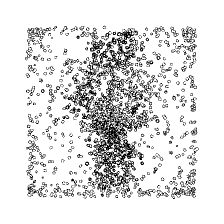

100%|██████████| 10/10 [00:07<00:00,  1.42it/s]

{'target_img_loss': 0.0655, 'overlap_loss': 0.0006, 'out_of_bounds_loss': 0.00231}
tensor([0.0684], device='cuda:0', grad_fn=<AddBackward0>)
{'target_img_loss': 0.0655, 'overlap_loss': 0.0006, 'out_of_bounds_loss': 0.00231}


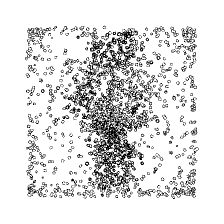

In [315]:

for ii in tqdm(range(10)):
    outputs, losses, scaled_losses, loss = train_flex(
    canvas_net=canvas_net, 
    optim=optim, 
    loss_funcs=loss_funcs,
    loss_weights=loss_weights,
    )
    if ii % save_freq == 0:
        
        display.clear_output(wait=True)
        temp = NamedTemporaryFile(mode="wb", suffix='.png', delete=False)
        with  temp as fp:
            gdg.to_pil(outputs['img']).save(fp)
        display.display(display.Image(temp.name))
        
        fp = nft_dir.joinpath(f'{frame_counter:04d}.png')
        # gdg.to_pil(outputs['img']).save(fp)
        
        shape_groups = outputs['shape_groups']
        with torch.no_grad():
            shapes_tensors = outputs['tensors']['shapes_tensors']
            upscaled_shapes_tensors = {key: tensor.clone() for key, tensor in shapes_tensors.items()}
            shapes, upscaled_tensors = upscaler.forward(upscaled_shapes_tensors)
        canvas = gdg.Canvas(width=int(224*upscale_factor), height=int(224*upscale_factor), draw_white_background=True)
        canvas.render(shapes, shape_groups, as_pil=True).save(fp)
        
        
        frame_counter += 1
        print({k: np.round(float(v),5) for k, v in scaled_losses.items()})
print(loss)
print({k: np.round(float(v),5) for k, v in scaled_losses.items()})
img = outputs['img']
gdg.to_pil(img)

In [ ]:
nft_dir = Path('/home/naka/art/raster_videos/20220704-153306_850908-c759e-4e0e0b')

In [ ]:
nft_id = '20220704-153306_850908-c759e-4e0e0b'

In [ ]:
upscale_factor=5
shape_groups = outputs['shape_groups']
with torch.no_grad():
    shapes_tensors = outputs['tensors']['shapes_tensors']
    upscaled_shapes_tensors = {key: tensor.clone() for key, tensor in shapes_tensors.items()}
    shapes, upscaled_tensors = upscaler.forward(upscaled_shapes_tensors)


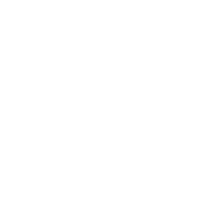

In [ ]:

canvas = gdg.Canvas(width=int(224*1), height=int(224*1), draw_white_background=True)
canvas.render(shapes, shape_groups, as_pil=True)
# gdg.to_pil(nn.functional.interpolate(img, size=(600, 600), mode='nearest-exact'))

In [ ]:
filenames = sorted([fp.as_posix() for fp in nft_dir.glob('*.png')])
import moviepy
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
clipout = ImageSequenceClip(filenames, fps=60)
clipout.write_videofile(nft_dir.joinpath(f'{nft_id}.mp4').as_posix())
len(filenames)

t:   0%|          | 0/1025 [00:00<?, ?it/s, now=None]

Moviepy - Building video /home/naka/art/raster_videos/20220704-165720_363770-c759e-4904f6/20220704-165720_363770-c759e-4904f6.mp4.
Moviepy - Writing video /home/naka/art/raster_videos/20220704-165720_363770-c759e-4904f6/20220704-165720_363770-c759e-4904f6.mp4



Moviepy - Done !
Moviepy - video ready /home/naka/art/raster_videos/20220704-165720_363770-c759e-4904f6/20220704-165720_363770-c759e-4904f6.mp4


1024